In this notebook we implement Tensorboard logging using PyTorch `SummaryWriter`, as reviewed in the previous notebook. This is implemented in the linear regression problem. 

In [1]:
import torch
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import helpers as h
from math import floor, ceil

from torch.utils.tensorboard import SummaryWriter

In [2]:
writer = SummaryWriter('runs/linear_regression')

In [3]:
# Set the random seed for reproducibility
torch.manual_seed(42)

### Generating the Input Data
Each instance (data entry) represents a point in a two-dimensional space $(x_i,y_i)$. The data points are generated around a line defined by its slope and intercept with the y-axis (at $x=0$). The x-values are chosen randomly from a given range. The y-values are generated according to the $x$ and the linear equation, with a random uniform noise around it.   

In [4]:
NUMBER_OF_DATA_POINTS = 4
X_RANGE = {
    'min': 0.,
    'max': 2.
}
SLOPE = 3
INTERCEPT = 4
NOISE_RANGE = 1.5

def generate_data(
    x_range:dict[str, float]=X_RANGE,
    number_of_data_points:int=NUMBER_OF_DATA_POINTS,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE
    ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates data for linear regression.
    """
    range = X_RANGE['max'] - X_RANGE['min']
    X = x_range['min'] + (range * torch.rand(size=(number_of_data_points, 1)))  # randomly-generated x-values, taken from a uniform distribution within `x_range`
    y = intercept + (slope * X) + (((torch.rand(size=(number_of_data_points, 1)) - 0.5) * 2) * noise_range)  # y-values with uniformaliy distributed noise added
    return X, y

X, y = generate_data()

In [5]:
h.print_tensor_info(X, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.7645],
        [1.8300],
        [0.7657],
        [1.9186]])
Dimension    2
Shape        (4, 1)


In [6]:
h.print_tensor_info(y, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[ 8.9650],
        [ 9.7927],
        [ 5.5669],
        [10.6368]])
Dimension    2
Shape        (4, 1)


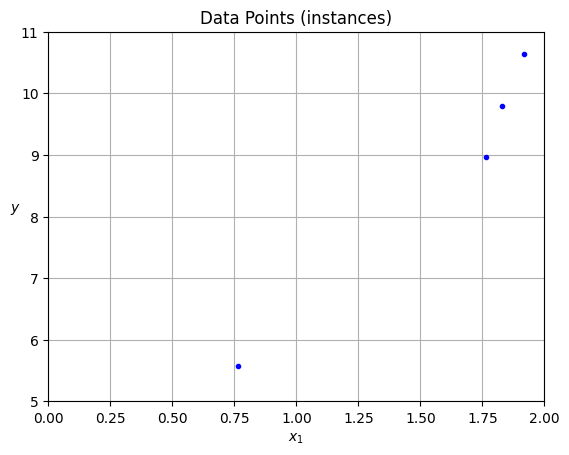

In [7]:
def plot_data_points(X, y):
    plt.plot(X, y.detach().numpy(), "b.")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.title("Data Points (instances)")
    plt.axis([X_RANGE['min'], X_RANGE['max'], floor(y.min()), ceil(y.max())])
    plt.grid()
    plt.show()
    return

plot_data_points(X, y)

### Defining the Model
Notice that the parameters ($weight$ and $bias$) are defined as part of the model, and are initialized.

In [8]:
model = nn.Linear(in_features=1, out_features=1)

In [9]:
print(model)

Linear(in_features=1, out_features=1, bias=True)


In [10]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Parameter: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: Linear(in_features=1, out_features=1, bias=True)


Parameter: weight | Size: torch.Size([1, 1]) | Values : tensor([[0.8815]], grad_fn=<SliceBackward0>) 

Parameter: bias | Size: torch.Size([1]) | Values : tensor([-0.7336], grad_fn=<SliceBackward0>) 



In [11]:
writer.add_graph(model, X)

In [12]:
def predict(X: torch.Tensor) -> torch.Tensor:
    """
    Calculates the value of the model, at points X.
    Parameters:
    ----------
    X: torch tensor of shape (number_of_points_to_predict, 1), representing the x-values of the points to predict
    Returns:
    -------
    y_predicted: a torch tensor of shape (number_of_points_to_predict, 1), representing the predicted y-values of the points according to the model
    """
    return model(X)

In [13]:
y_predicted = predict(X)

In [14]:
h.print_tensor_info(y_predicted, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[ 0.8219],
        [ 0.8796],
        [-0.0586],
        [ 0.9577]], grad_fn=<AddmmBackward0>)
Dimension    2
Shape        (4, 1)


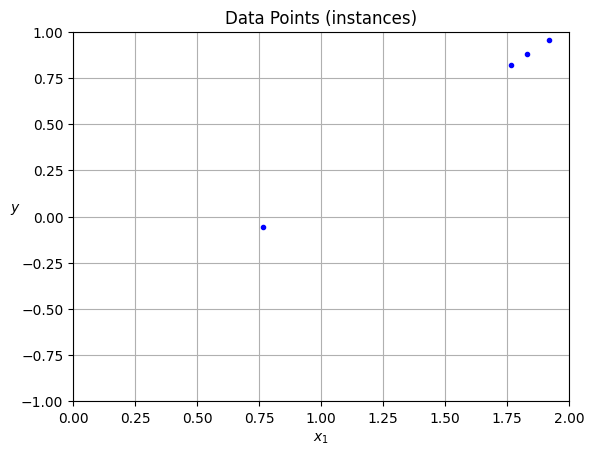

In [15]:
plot_data_points(X, y_predicted)

### Setting up a Loss Function

The loss function we are going to use is the mean squared error (MSE):

$\frac{1}{m}*\sum_{n=1} ^{m} (y_{predicted, n} - y_n)^2$

In [16]:
loss_fn = nn.MSELoss()
loss = loss_fn(y_predicted, y)

In [17]:
h.print_tensor_info(loss, fields=['Tensor', 'Dimension', 'Shape'])

67.77084350585938
Dimension    0
Shape        ()


### Optimization

In [18]:
lr = 0.01
print(f'Learning Rate: {lr:.4}')

Learning Rate: 0.01


In [19]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [20]:
def train_iteration(X, y, model, loss_fn, optimizer):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [21]:
print('Epoch 0, Loss %f' % (float(loss.item())))
writer.add_scalar(
    tag='training loss',
    scalar_value=loss,
    global_step=0,
)
epochs = 100
for epoch in range(1, epochs):
    loss = train_iteration(X, y, model, loss_fn, optimizer)
    writer.add_scalar(
        tag='training loss',
        scalar_value=loss,
        global_step=epoch,
    )
    if (epoch+1) % 10 == 0:
            print('Epoch %d, Loss %f' % (epoch+1, float(loss.item())))
print("Done")

Epoch 0, Loss 67.770844
Epoch 10, Loss 20.490778
Epoch 20, Loss 4.712932
Epoch 30, Loss 1.205370
Epoch 40, Loss 0.424700
Epoch 50, Loss 0.250062
Epoch 60, Loss 0.210131
Epoch 70, Loss 0.200163
Epoch 80, Loss 0.196880
Epoch 90, Loss 0.195108
Epoch 100, Loss 0.193697
Done


In [22]:
writer.close()